# LSTM - bert128

- **Training set**: LO_SARD102(0.6 split)
- **Test/Validation set:** LO_SARD102 (0.2 split)
- **Features**: bert sequence (128)
- **Class imbalance processing**: SMOTE

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert128_X.npy')
y = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert128_y.h5').is_vulnerable.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.25, random_state=10)

del X
del y


# oversample class 1
X_train, Y_train = oversample_smote(np.reshape(X_train, (-1, 128*768)), Y_train )

X_train = np.reshape( X_train, (-1, 128, 768) )

print("class counts oversampled data set:", (X_train.shape[0], Y_train.shape[0]))

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

imbalanced_learn version  0.7.0
Counter output before SMOTE: Counter({0: 30438, 1: 274})
Counter output after SMOTE: Counter({0: 30438, 1: 30438})
class counts oversampled data set: (60876, 60876)
(60876, 128, 768)
(60876,)
(10238, 128, 768)
(10238,)
(10238, 128, 768)
(10238,)


## Variant 1

In [25]:
def oversample_smote(X, y):
    from imblearn.over_sampling import SMOTE
    # summarize the new class distribution
    counter = Counter(y)
    print("Counter output before SMOTE:", counter)
    
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    
    # summarize the new class distribution
    counter = Counter(y)
    print("Counter output after SMOTE:", counter)
    return X, y


def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    
    model = keras.Sequential()
    model.add(layers.LSTM(512, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add( layers.TimeDistributed(layers.Dense(256)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(64))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=512,
                        epochs=4,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


model, history = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 512)          2623488   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 512)          0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 128, 256)          131328    
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dense_40 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10146
           1       0.84      0.98      0.90        92

    accuracy                           1.00     10238
   macro avg       0.92      0.99      0.95     10238
weighted avg       1.00      1.00      1.00     10238

Confusion matrix:
[[10129    17]
 [    2    90]]

Confusion matrix (Percentages):
[[9.8935e+01 1.6600e-01]
 [2.0000e-02 8.7900e-01]]

Metrics:
Sensitivity (TPR): 0.978261
Specifity (TNR):   0.998324

FPR: 0.001676
FNR: 0.021739

Balanced accuracy: 0.988293

Test loss:	0.008766
Test accuracy:	0.998144


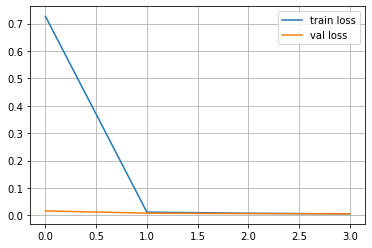

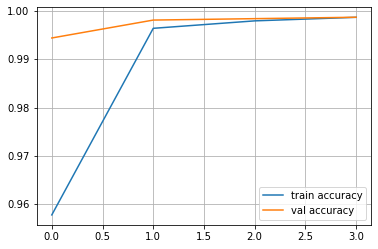

In [26]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history)


evaluate_classifier(model, history)

In [27]:
model.save('LSTM_Var1_bert128_SMOTE')
model.save('LSTM_Var1_bert128_SMOTE.h5')

INFO:tensorflow:Assets written to: LSTM_Var1_bert128_SMOTE/assets


## Variant 2

In [32]:
def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    
    model = keras.Sequential()
    model.add(layers.LSTM(64, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add(layers.LSTM(16, return_sequences=True))
    model.add( layers.TimeDistributed(layers.Dense(16)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=512,
                        epochs=4,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


modelv2, historyv2 = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128, 64)           213248    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128, 16)           5184      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 128, 16)           272       
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2049      
Total params: 220,753
Trainable params: 220,753
Non-trainable params: 0
_______________________________________________

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10146
           1       0.85      0.98      0.91        92

    accuracy                           1.00     10238
   macro avg       0.92      0.99      0.95     10238
weighted avg       1.00      1.00      1.00     10238

Confusion matrix:
[[10130    16]
 [    2    90]]

Confusion matrix (Percentages):
[[9.8945e+01 1.5600e-01]
 [2.0000e-02 8.7900e-01]]

Metrics:
Sensitivity (TPR): 0.978261
Specifity (TNR):   0.998423

FPR: 0.001577
FNR: 0.021739

Balanced accuracy: 0.988342

Test loss:	0.008696
Test accuracy:	0.998242


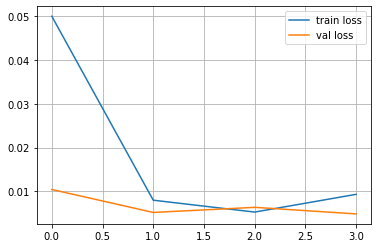

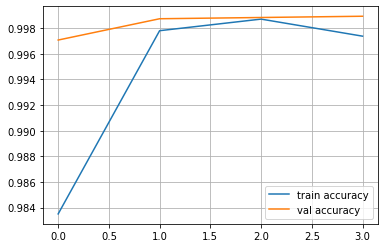

In [33]:
evaluate_classifier(modelv2, historyv2)

In [34]:
modelv2.save('LSTM_Var2_bert128_SMOTE')
modelv2.save('LSTM_Var2_bert128_SMOTE.h5')

INFO:tensorflow:Assets written to: LSTM_Var2_bert128_SMOTE/assets
